In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import datetime
import glob
%matplotlib inline

# Test camera

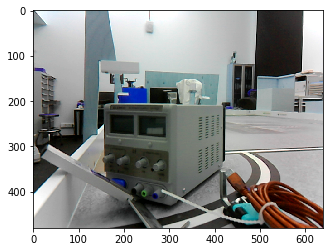

In [5]:
cap = cv2.VideoCapture(0)
time.sleep(0.1)
ret, frame = cap.read()
plt.imshow(frame)

# Calibrate camera

In [9]:
CHECKERBOARD = (7, 5)
# N = 15
subpix_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('calibration_imgs/*.png')
# n = 0
for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret == True:
#         n += 1
#         if n > N:
#             break
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners, CHECKERBOARD,(-1,-1),subpix_criteria)
        imgpoints.append(corners)

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, K, D, _, _ = \
    cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

Found 42 valid images for calibration
DIM=(1600, 1200)
K=np.array([[2173.545704049685, 0.0, 649.1090711080768], [0.0, 2202.819365846337, 679.7753849081377], [0.0, 0.0, 1.0]])
D=np.array([[0.05746927376128883, 8.143745812500415, -0.009325795655845955, -0.07330106742114555, -19.78540040956083]])


In [10]:
K=np.array([[2173.545704049685, 0.0, 649.1090711080768], [0.0, 2202.819365846337, 679.7753849081377], [0.0, 0.0, 1.0]])
D=np.array([[0.05746927376128883, 8.143745812500415, -0.009325795655845955, -0.07330106742114555, -19.78540040956083]])

# Load image

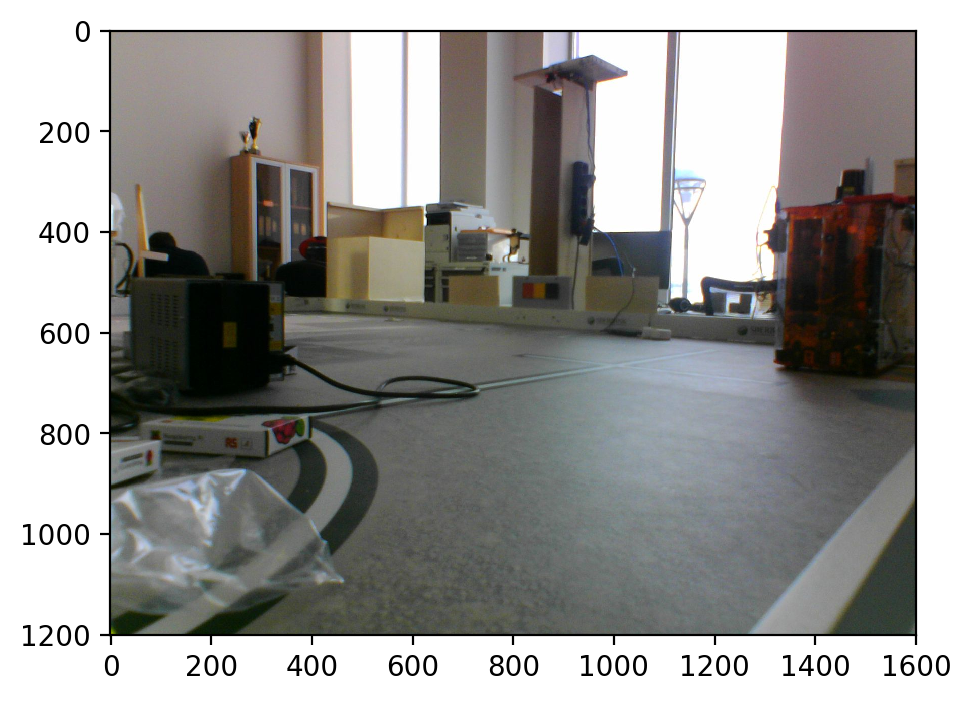

In [35]:
img = cv2.imread("imgs/142_ld_p45_1.png") 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR));

# Transformation matrix

In [46]:
def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

R = eulerAnglesToRotationMatrix((-np.pi / 2, -np.pi / 4, np.pi))
camera_position = np.array([[-65], [2000 - 70], [135]])
t = -R.dot(camera_position)
M = np.concatenate((R, t), axis=1)
h_border = 60 * 8
w_border = 60 * 10
L = np.array([[-1, 0, 1500 + w_border / 2], [0, 0, 0], [0, -1, 135 + h_border / 2],
                         [0, 0, 1]])
Tr = np.linalg.inv(K.dot(M).dot(L)) * 1000

In [47]:
Tr / Tr[2, 2]

array([[ 2.48944424e+00, -1.96284103e-16, -1.70859801e+03],
       [ 1.57435209e-01,  1.76665937e+00, -9.60931553e+02],
       [ 6.55980038e-04, -2.32167103e-20,  1.00000000e+00]])

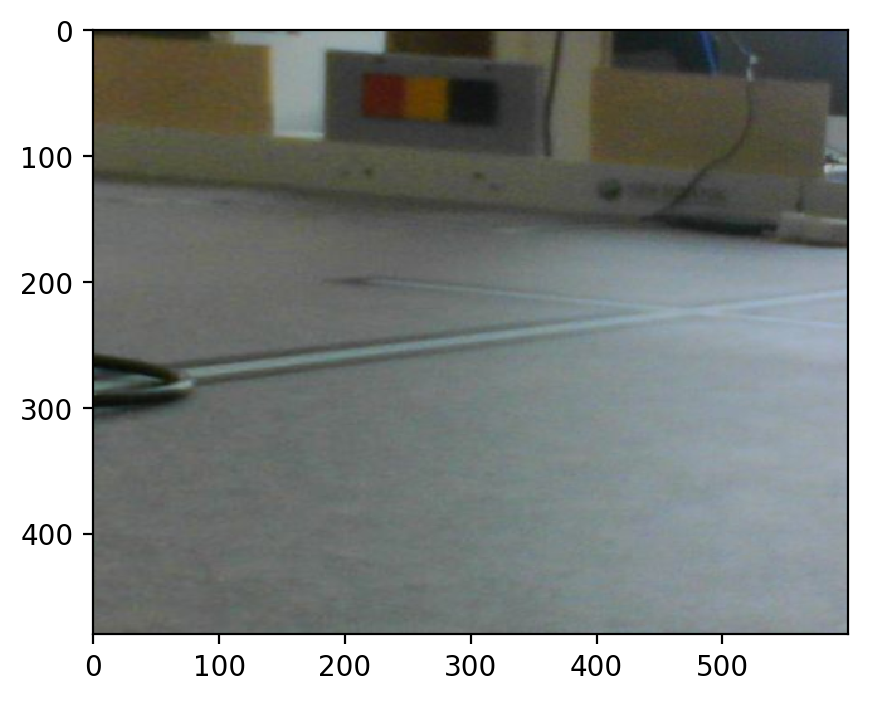

In [48]:
tr_img = cv2.warpPerspective(img, Tr, (w_border, h_border))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(cv2.cvtColor(tr_img, cv2.COLOR_RGB2BGR));

In [27]:
M.dot(np.array([[0], [0], [0], [1]]))

array([[1414.21356237],
       [ 135.        ],
       [1414.21356237]])